In [2]:
from __future__ import division

from pylab import *
import scipy
import time
import utils
import hrr_utils
import RM_utils

#import imnet_utils as imut
import sklearn
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, NMF
from scipy import stats

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'text.usetex': True})

In [17]:
def ngram_encode(ngram_str, letter_vecs, alph):
    vec = np.zeros(letter_vecs.shape[1])
    
    full_str = '#' + ngram_str + '.'
    
    
    for il, l in enumerate(full_str[:-2]):
        trivec = letter_vecs[alph.find(full_str[il]), :]
        for c3 in range(1, 3):
            trivec = trivec * np.roll(letter_vecs[alph.find(full_str[il+c3]), :], c3)
            
        vec += trivec
    return vec

def ngram_encode_cl(ngram_str, letter_vecs, alph):
    vec = ngram_encode(ngram_str, letter_vecs, alph)
    return 2* (vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) > 0) - 1

def sim(x, y):
    if len(x.shape) == 1 or len(y.shape)==1:
        return np.dot(x, y)
    return np.sum(np.multiply(x, y), axis=1)

def initialize(letter_vecs, N, D, state_length=5, n_steps=500):
    states = []
    coef_hists = []
    
    for i in range(state_length):
        states.append(np.random.randn(N))
    
    for i in range(1, state_length-1):
        states[i] = np.dot(letter_vecs.T, np.dot(states[i], letter_vecs.T))

    for i in range(1, state_length-1):
        states[i] = states[i]/norm(states[i])

    states[0] = letter_vecs[alph.find('#'), :]
    states[state_length-1] = letter_vecs[alph.find('.'), :]
    
    for i in range(1, state_length-1):
        coef_hists.append(np.zeros((n_steps, D)))
    
    return states, coef_hists

def train(bound_vec, states, coef_hists, letter_vecs, n_steps=500):
    th_vec = bound_vec.copy()

    for i in range(n_steps):
        coef_hists[0][i, :] = np.dot(letter_vecs, states[1])
        coef_hists[1][i, :] = np.dot(letter_vecs, states[2])
        coef_hists[2][i, :] = np.dot(letter_vecs, states[3])

        mx1idx = np.argmax(np.abs(coef_hists[0][i,:]))
        states[1] *= np.sign(coef_hists[0][i, mx1idx])
        mx2idx = np.argmax(np.abs(coef_hists[1][i,:]))
        states[2] *= np.sign(coef_hists[1][i, mx2idx])
        mx3idx = np.argmax(np.abs(coef_hists[2][i,:]))
        states[3] *= np.sign(coef_hists[2][i, mx3idx])


        l1d = (np.roll(th_vec * states[0] * np.roll(states[2], 2), -1) +
              th_vec * np.roll(states[2], 1) * np.roll(states[3], 2)) / 2

        l2d = (np.roll(th_vec * states[0] * np.roll(states[1], 1), -2) +
                np.roll(th_vec * states[1] * np.roll(states[3], 2), -1) +
                  th_vec * np.roll(states[3], 1) * np.roll(states[4], 2)) / 3

        l3d = (np.roll(th_vec * states[2] * np.roll(states[4], 2), -1) +
               np.roll(th_vec * states[1] * np.roll(states[2], 1), -2)) / 2

        states[1] = np.dot(letter_vecs.T, np.dot(l1d, letter_vecs.T)/N) + 1.0*states[1]
        states[2] = np.dot(letter_vecs.T, np.dot(l2d, letter_vecs.T)/N) + 1.0*states[2]
        states[3] = np.dot(letter_vecs.T, np.dot(l3d, letter_vecs.T)/N) + 1.0*states[3]

        bv = (states[0] * np.roll(states[1],1) * np.roll(states[2],2) 
              +states[1] * np.roll(states[2],1) * np.roll(states[3],2) 
              +states[2] * np.roll(states[3],1) * np.roll(states[4],2) )

        th_vec = bound_vec - bv
    return states, coef_hists
        

def explain_away(bound_vec, states, coef_hists, state_length, letter_vecs, N, D, max_steps=500, atol=0.0165, rtol=0.007):
    th_vec = bound_vec.copy()
    all_converged = np.zeros(state_length-2)
    for i in range(max_steps):

        for j in range(1, state_length-1):
            coef_hists[j-1][i, :] = np.dot(letter_vecs, states[j])
            if i > 1:
                all_converged[j-1] = np.allclose(coef_hists[j-1][i,:], coef_hists[j-1][i-1, :],
                                                atol=atol, rtol=rtol)

        
        for j in range(1, state_length-1):
            mxidx = np.argmax(np.abs(coef_hists[j-1][i,:]))
            states[j] *= np.sign(coef_hists[j-1][i, mxidx])
        ljds = []
        for j in range(1, state_length-1):
            if j == 1:
                ljds.append(
                    (np.roll(th_vec * states[0] * np.roll(states[2], 2), -1) +
                    th_vec * np.roll(states[2], 1) * np.roll(states[3], 2)) / 2
                )
            elif 1 < j < state_length-2:
                ljds.append(
                    (np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2) +
                    np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                      th_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 3
                )
            else:
                ljds.append(
                    (np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                   np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2)) / 2
                )

        for j in range(1, state_length-1):    
            states[j] = np.dot(letter_vecs.T, np.dot(ljds[j-1], letter_vecs.T)/N) + 1.0*states[j]
        
        if np.all(all_converged):
            break
            
        bv = states[0] * np.roll(states[1],1) * np.roll(states[2],2)  
        for j in range(1, state_length-2):
            bv += states[j] * np.roll(states[j+1],1) * np.roll(states[j+2],2) 
         
        th_vec = bound_vec - bv

    return states, coef_hists, all_converged, i

def spell(coef_hists):
    pred = ''
    alphis = []

    for i in range(len(coef_hists)):
        x, alphi = np.unravel_index(coef_hists[i].argmax(), coef_hists[i].shape)
        pred += alph[alphi]
        alphis.append(alphi)

    return pred, alphis
    
def resplot(word_length, states, coef_hists, N, nsteps, start):
    
    pred, alphis = spell(coef_hists)
    print pred
    rows = 1
    columns = word_length

    fig, axes = plt.subplots(rows, columns, sharex='all', squeeze=True, figsize=(25,5))
    cols = get_cmap('copper', min(500,n_steps))
    x = np.linspace(0,len(alph)-2,len(alph)-2)
    labels = list(alph)
    plt.xticks(x, labels)
    
    for j in range(word_length):
        for i in range(start, min(500,n_steps)):
            # graphing the max positive at every iteration is not intuitive, since we should
            # be focusing on how our predicted letter's probability increases over time
            coef_hists[j][i,alphis[j]] = np.abs(coef_hists[j][i,alphis[j]])
            axes[j].plot(coef_hists[j][i,:], lw=1.7, c=cols(i))
            
        step, alphi = np.unravel_index(coef_hists[j].argmax(), coef_hists[j].shape)
        axes[j].plot(alphi, coef_hists[j][step, alphi], '+')

    #plt.savefig('figures/'+title+pred+'-N='+str(N)+'-steps='+str(nsteps)+'-reg='+reg+'.svg')
    
def accuracy(pred, actual):
    acc = 0
    for i in range(len(pred)):
        if pred[i] == actual[i]:
            acc += 1
    return acc / float(len(pred))


In [4]:
# 1
alph = 'abcdefghijklmnopqrstuvwxyz#.'

N = 10000
D = len(alph)

letter_vecs = 2 * (np.random.randn(D, N) < 0) - 1
letter_vecs1 = 2 * (np.random.randn(D, N) < 0) - 1

word_key = 2 * (np.random.randn(N) < 0) - 1

present_strs = ['run', 'walk', 'watch', 'catch', 'sit', 'jump', 'lump', 'bump', 'think']
past_strs = ['ran', 'walked', 'watched', 'caught', 'sat', 'jumped', 'lumped', 'bumped', 'thought']
#present_strs = ['run', 'walk']
#past_strs = ['ran', 'walked']

ngram_strs = present_strs + past_strs
bound_vec = np.zeros(N)
reg_bound_vec = np.zeros(N)
n_steps = 200

for i in range(len(past_strs)):
    past = ngram_encode_cl(past_strs[i], letter_vecs, alph)
    pres = ngram_encode_cl(present_strs[i], letter_vecs, alph)
    past1 = ngram_encode_cl(past_strs[i], letter_vecs1, alph)
    pres1 = ngram_encode_cl(present_strs[i], letter_vecs1, alph)
    
    bound_diff = pres * (past1 - pres1)
    pred = reg_bound_vec*pres + pres1

    bound_vec += bound_diff
    reg_bound_vec += ((N-sim(pred, past1))/float(N)) * bound_diff

In [5]:
# predict a word in bound_vec
# regularized bind
seen = 'seen-'
word = 'catch'
word_length = 6
word_vec = ngram_encode_cl(word, letter_vecs, alph)
word_vec1 = ngram_encode_cl(word, letter_vecs1, alph)

pred_vec = word_vec * bound_vec + word_vec1

In [6]:
# predict a word not bound_vec
# regularized bind
seen = 'unseen-'
word = 'pump'
word_length = 6
word_vec = ngram_encode_cl(word, letter_vecs, alph)
word_vec1 = ngram_encode_cl(word, letter_vecs1, alph)

pred_vec = word_vec * bound_vec + word_vec1

In [7]:
states, coef_hists = initialize(letter_vecs1, N, D, word_length+2, n_steps)
states, coef_hists, all_converged, i = explain_away(
    pred_vec, states, coef_hists, word_length+2, letter_vecs1, N, D, n_steps, 0.34, 0.264)#, atol=0, rtol=0)

122
pumped


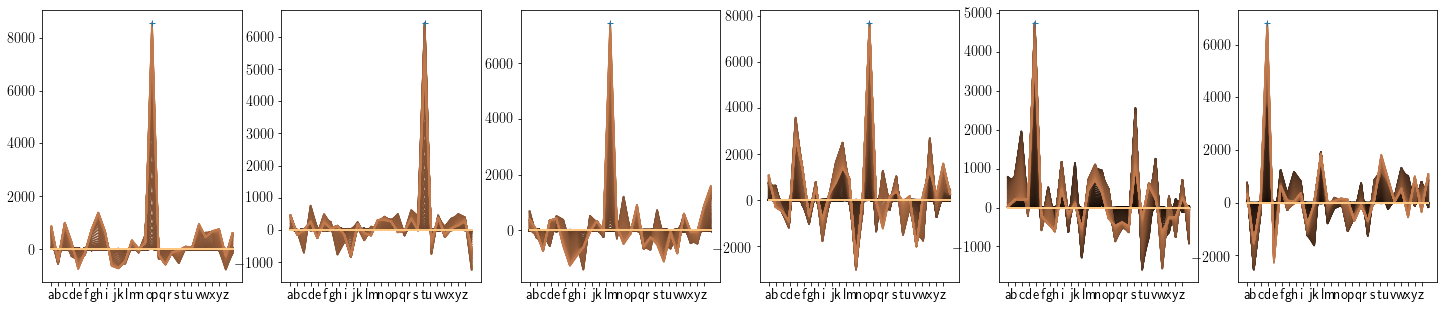

In [18]:
print i
resplot(word_length, states, list(coef_hists), N, n_steps, 0)

In [12]:
for j in range(len(coef_hists)):
    x, alphi = np.unravel_index(coef_hists[j].argmax(), coef_hists[j].shape)
    print (alphi, alph[alphi])

(15, 'p')
(20, 'u')
(12, 'm')
(15, 'p')
(4, 'e')
(3, 'd')


In [20]:
# 2
accs = []
binaccs = []
convsteps = []

# atol = 0.0165
# rtol = 0.007

# atol = 0.034
# rtol = 0.0264

atol = 0.34
rtol = 0.264

N = 1000
n_steps = 500

word = 'pneumonoultramicroscopicsilicovolcanoconiosis'
# noise 
for sigma in range(5):
    accs.append([])
    binaccs.append([])
    convsteps.append([])
    print ('sigma', sigma*.01)

    # N-neurons
    for i in range(11):
        N = 1000*(2**i)
        noise = np.random.normal(0, sigma*.01, N)
        dic1 = 2 * (np.random.randn(D, N) < 0) - 1
        accs[sigma].append([])
        binaccs[sigma].append([])
        convsteps[sigma].append([])
        print ('N', N)
        
        # M-letter word
        for word_length in range(2,len(word),3):
            word_vec = ngram_encode_cl(word[:word_length], dic1, alph) + noise
            
            states, coef_hists = initialize(dic1, N, D, word_length+2, n_steps)
            states, coef_hists, all_converged, steps = explain_away(
                word_vec, states, coef_hists, word_length+2, dic1, N, D, n_steps, atol, rtol)

            pred, alphis = spell(coef_hists)
            actual = word[:word_length]
            print (pred, actual, steps)
            accs[sigma][i].append(accuracy(pred, actual))
            binaccs[sigma][i].append(1 if pred == actual else 0)
            convsteps[sigma][i].append(steps)


('sigma', 0.0)
('N', 1000)
('pn', 'pn', 30)
('pneum', 'pneum', 61)
('pneumono', 'pneumono', 175)
('wsjq.sgcbtm', 'pneumonoult', 499)
('pneysalxkfo#vd', 'pneumonoultram', 499)


/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:123: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in add


('aaaaaaaaaaaaaaaaa', 'pneumonoultramicr', 499)


/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in add
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in add
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in add
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: overflow encounte

('aaaaaaaaaaaaaaaaaaaa', 'pneumonoultramicrosc', 499)
('dseknrlvszlhbrwly#sdkge', 'pneumonoultramicroscopi', 499)
('aaaaaaaaaaaaaaaaaaaaaaaaaa', 'pneumonoultramicroscopicsi', 499)


/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: overflow encountered in add
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: overflow encountered in add


('aaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'pneumonoultramicroscopicsilic', 499)
('aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'pneumonoultramicroscopicsilicovo', 499)
('aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'pneumonoultramicroscopicsilicovolca', 499)
('aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'pneumonoultramicroscopicsilicovolcanoc', 499)
('nbkzlmkp.y#ir.xas.pxqdhillsbzvaqpzlbgqven', 'pneumonoultramicroscopicsilicovolcanoconi', 499)
('aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'pneumonoultramicroscopicsilicovolcanoconiosi', 499)
('N', 2000)
('aa', 'pn', 499)
('pneum', 'pneum', 83)
('pneuwono', 'pneumono', 499)
('pneumonoult', 'pneumonoult', 274)
('pneumonoultram', 'pneumonoultram', 207)
('izbcqaifrnpetdpon', 'pneumonoultramicr', 499)
('ewehzhvk#mj.knfnbrsm', 'pneumonoultramicrosc', 499)
('pnrsygtep.bdqdmv.lqtwol', 'pneumonoultramicroscopi', 499)
('ikoc.icxy#fnflvwmw.cefxrbo', 'pneumonoultramicroscopicsi', 499)
('zgdidyjqbsfxxjyccmfnkloscopic', 'pneumonoultramicroscopicsilic', 499)
('aaaaaaaaaaaaaaa

KeyboardInterrupt: 

In [21]:
        
fname = ('data/res_word_trigram-03-29-2018-N=' + str(N) + '-D=' + str(D) + 
         '-n' + time.strftime('%y%m%d') + '.npz')

np.savez(fname, accs=accs, binaccs=binaccs, convsteps=convsteps,
         N=N, D=D, atol=atol, rtol=rtol)


(3,)


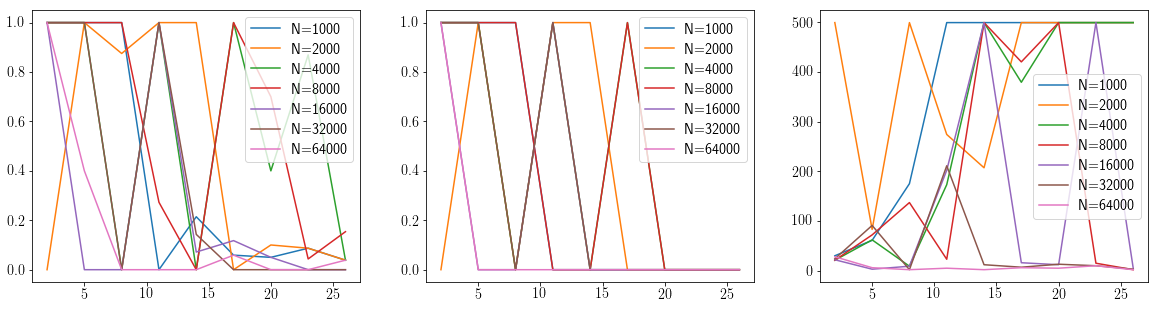

In [40]:
f = np.load('data/res_word_trigram-03-29-2018-N=64000-D=28-n180402.npz')

temp_word = 'pneumonoultramicroscopicsilic'
rows = len(f['accs'])

columns = 3

fig, axes = plt.subplots(rows, columns, sharex='all', squeeze=True, figsize=(20,5))

print axes.shape
x = [i for i in range(2,len(temp_word),3)]

# for j in range(rows):
#     for k in range(0, len(f['accs'][j]), 2):
#         axes[j][0].plot(x, f['accs'][j][k], label='N='+str(1000*(2**k)))
#         axes[j][1].plot(x, f['binaccs'][j][k], label='N='+str(1000*(2**k)))
#         axes[j][2].plot(x, f['convsteps'][j][k], label='N='+str(1000*(2**k)))
#     axes[j][0].legend()
#     axes[j][1].legend()
#     axes[j][2].legend()
    

for k in range(0, len(f['accs'][0])):
    axes[0].plot(x, f['accs'][0][k][:len(x)], label='N='+str(1000*(2**k)))
    axes[1].plot(x, f['binaccs'][0][k][:len(x)], label='N='+str(1000*(2**k)))
    axes[2].plot(x, f['convsteps'][0][k][:len(x)], label='N='+str(1000*(2**k)))
axes[0].legend()
axes[1].legend()
axes[2].legend()
    

In [ ]:
# 3
alph = 'abcdefghijklmnopqrstuvwxyz#.'

N = 5000
D = len(alph)

dic1 = 2 * (np.random.randn(D, N) < 0) - 1
dic2 = 2 * (np.random.randn(D, N) < 0) - 1

word = 'pneumonoultramicroscopicsilicovolcanoconiosis'

pres_categories, past_categories = RM_utils.exemplars()
verbs = []
testverbs = []
rat = 2/3

for key in pres_categories.keys():
    total = len(past_categories[key])
    cutoff = int(total*rat)
    for i in range(total):
        if i < cutoff:
            verbs.append([past_categories[key][i], pres_categories[key][i]])
        else:
            testverbs.append([
                past_categories[key][i],
                pres_categories[key][i]
            ])

verbs.append(['jumped', 'jump'])
verbs.append(['walked', 'walk'])
testverbs.append(['jolted', 'jolt'])

verbs = verbs[:1]
testverbs = testverbs[:1]


In [ ]:
diff, pres1, pres2, past1, past2 = RM_utils.genX(verbs, N, dic1, dic2, alph)
testdiff, testpres1, testpres2, testpast1, testpast2 = RM_utils.genX(testverbs, N, dic1, dic2, alph)

bound_vec = np.zeros(N)
bound_vec = RM_utils.train_diff_bulk(bound_vec, past2, pres1, pres2, N)

In [ ]:
nsteps = 500
n_steps = 100
atol = 0.034
rtol = 0.264

# train set
for i in range(len(verbs)):
    past, pres = verbs[i][0], verbs[i][1]
    word_length = len(past)
    pred_vec = pres1[i] * bound_vec + pres2[i]

    states, coef_hists = initialize(dic2, N, D, word_length+2, nsteps)
    states, coef_hists, all_converged, steps = explain_away(
        bound_vec, states, coef_hists, word_length+2, dic2, 
        N, D, nsteps, atol, rtol)
 
    pred, alphis = spell(coef_hists)
    print (pred, past, alphis, steps)

    resplot(word_length, states, coef_hists, N, nsteps, 0)
    
# print ('test set')
# for i in range(len(testverbs)):
#     past, pres = testverbs[i][0], testverbs[i][1]
#     word_length = len(past)
#     pred_vec = testpres1[i] * bound_vec + testpres2[i]
    
#     states, coef_hists = initialize(dic2, N, D, word_length+2, nsteps)
#     states, coef_hists, all_converged, steps = explain_away(
#         bound_vec, states, coef_hists, word_length+2, dic2, 
#         N, D, nsteps, atol, rtol)


#     pred, alphis = spell(coef_hists)

#     print (pred, past, alphis, steps)

#     resplot(word_length, states, coef_hists, N, nsteps, 0)


In [ ]:
# 4
alph = 'abcdefghijklmnopqrstuvwxyz#.'

N = 1000
D = len(alph)

letter_vecs = 2 * (np.random.randn(D, N) < 0) - 1


ngram_str = 'pax'

bound_vec = ngram_encode_cl(ngram_str, letter_vecs, alph)

nsteps = 100
atol = 0.034
rtol = 0.0264
state_length = 5

states, coef_hists = initialize(letter_vecs, N, D, state_length, nsteps)
states1, coef_hists1 = copy(states), copy(coef_hists)
    
states, coef_hists = train(bound_vec, states, coef_hists, letter_vecs, nsteps)
states1, coef_hists1, all_converged, steps = explain_away(
    bound_vec, states1, coef_hists1, state_length, 
    letter_vecs, N, D, nsteps, atol, rtol)

pred = spell(coef_hists)
pred1 = spell(coef_hists1)
print (pred, pred1, steps)

In [ ]:
print ('states')
for i in range(len(states1)):
    print np.all(states[i] == states1[i])
print ('coef_hists')
for i in range(len(coef_hists1)):
    print np.all(coef_hists[i] == coef_hists1[i])

In [ ]:
# 5

atols = []
rtols = []

alph = 'abcdefghijklmnopqrstuvwxyz#.'

N = 1000
D = len(alph)

word_length = 4
nsteps = 500

word = 'pneumonoultramicroscopicsilicovolcanoconiosis'

for i in range(2,100):
    for j in range(1,100):
#         print ('i,j', i, j)
        atol = i*.0005
        rtol = j*.0005
        
        dic1 = 2 * (np.random.randn(D, N) < 0) - 1
        
        word_vec = ngram_encode_cl(word[:word_length], dic1, alph)

        states, coef_hists = initialize(dic1, N, D, word_length+2, nsteps)
        states, coef_hists, all_converged, steps = explain_away(
            word_vec, states, coef_hists, word_length+2, dic1, N, D, nsteps, atol, rtol)

        pred, alphis = spell(coef_hists)
        actual = word[:word_length]
        
        if pred == actual:
            print (atol, rtol, pred, all_converged, steps)
            if np.all(all_converged): # and steps < nsteps-1:
                print ('atol', atol)
                print ('rtol', rtol)
                print (pred, actual, all_converged, steps)
                atols.append(atol)
                rtols.append(rtol)

(0.001, 0.0035, 'pneu', array([ 0.,  0.,  1.,  0.]), 499)


/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in add
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in add
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in add
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: overflow encounte

(0.001, 0.0095, 'pneu', array([ 0.,  0.,  0.,  0.]), 499)


/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in add
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:123: RuntimeWarning: overflow encountered in multiply


(0.001, 0.022, 'pneu', array([ 0.,  0.,  0.,  1.]), 499)
(0.0015, 0.0045000000000000005, 'pneu', array([ 1.,  1.,  0.,  1.]), 499)
(0.0015, 0.0195, 'pneu', array([ 0.,  0.,  0.,  0.]), 499)
(0.0015, 0.025500000000000002, 'pneu', array([ 0.,  0.,  0.,  0.]), 499)
(0.0015, 0.0455, 'pneu', array([ 1.,  1.,  0.,  1.]), 499)
(0.002, 0.001, 'pneu', array([ 0.,  0.,  0.,  0.]), 499)
(0.002, 0.0015, 'pneu', array([ 0.,  0.,  0.,  0.]), 499)
(0.002, 0.003, 'pneu', array([ 0.,  0.,  0.,  0.]), 499)
(0.002, 0.0035, 'pneu', array([ 0.,  0.,  0.,  0.]), 499)
(0.002, 0.004, 'pneu', array([ 0.,  0.,  0.,  0.]), 499)
(0.002, 0.01, 'pneu', array([ 0.,  0.,  1.,  1.]), 499)
(0.002, 0.015, 'pneu', array([ 0.,  0.,  0.,  0.]), 499)
(0.002, 0.025, 'pneu', array([ 1.,  0.,  1.,  1.]), 499)
(0.002, 0.027, 'pneu', array([ 0.,  0.,  0.,  0.]), 499)
(0.002, 0.0445, 'pneu', array([ 1.,  0.,  0.,  0.]), 499)
(0.002, 0.0485, 'pneu', array([ 1.,  1.,  0.,  1.]), 499)
(0.0025, 0.001, 'pneu', array([ 0.,  0.,  0.,  0

/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: overflow encountered in add


(0.003, 0.0365, 'pneu', array([ 0.,  0.,  0.,  0.]), 499)
(0.0035, 0.0025, 'pneu', array([ 1.,  1.,  0.,  1.]), 499)
(0.0035, 0.011, 'pneu', array([ 0.,  0.,  0.,  0.]), 499)
(0.0035, 0.043000000000000003, 'pneu', array([ 0.,  0.,  1.,  0.]), 499)
(0.004, 0.0025, 'pneu', array([ 0.,  0.,  0.,  0.]), 499)
(0.004, 0.0055, 'pneu', array([ 0.,  0.,  0.,  0.]), 499)
(0.004, 0.0305, 'pneu', array([ 0.,  1.,  1.,  1.]), 499)
(0.004, 0.047, 'pneu', array([ 0.,  0.,  0.,  0.]), 499)
(0.0045000000000000005, 0.006500000000000001, 'pneu', array([ 0.,  0.,  0.,  1.]), 499)
(0.0045000000000000005, 0.0095, 'pneu', array([ 0.,  0.,  0.,  0.]), 499)
(0.0045000000000000005, 0.0175, 'pneu', array([ 0.,  0.,  1.,  0.]), 499)
(0.0045000000000000005, 0.029, 'pneu', array([ 1.,  0.,  1.,  1.]), 499)
(0.0045000000000000005, 0.0495, 'pneu', array([ 0.,  0.,  0.,  0.]), 499)
(0.005, 0.004, 'pneu', array([ 0.,  0.,  0.,  0.]), 499)
(0.005, 0.021500000000000002, 'pneu', array([ 0.,  1.,  1.,  0.]), 499)
(0.005, 0

/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: overflow encountered in add
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: overflow encountered in add


(0.006, 0.012, 'pneu', array([ 0.,  0.,  0.,  0.]), 499)
(0.006, 0.027, 'pneu', array([ 0.,  0.,  0.,  0.]), 499)
(0.006, 0.029, 'pneu', array([ 1.,  1.,  1.,  0.]), 499)
(0.006, 0.042, 'pneu', array([ 1.,  1.,  0.,  0.]), 499)
(0.006500000000000001, 0.002, 'pneu', array([ 0.,  0.,  0.,  0.]), 499)
(0.006500000000000001, 0.02, 'pneu', array([ 0.,  1.,  0.,  1.]), 499)
(0.006500000000000001, 0.023, 'pneu', array([ 0.,  0.,  0.,  0.]), 499)
(0.006500000000000001, 0.025, 'pneu', array([ 1.,  0.,  1.,  1.]), 499)
(0.006500000000000001, 0.0475, 'pneu', array([ 0.,  0.,  0.,  0.]), 499)
(0.007, 0.0015, 'pneu', array([ 0.,  0.,  0.,  0.]), 499)
(0.007, 0.0025, 'pneu', array([ 0.,  0.,  0.,  0.]), 499)
(0.0075, 0.017, 'pneu', array([ 0.,  0.,  0.,  0.]), 499)
(0.008, 0.0285, 'pneu', array([ 0.,  0.,  0.,  0.]), 499)
(0.0085, 0.0015, 'pneu', array([ 0.,  0.,  0.,  0.]), 499)
(0.0085, 0.0035, 'pneu', array([ 0.,  0.,  0.,  0.]), 499)
(0.0085, 0.004, 'pneu', array([ 0.,  0.,  0.,  0.]), 499)
(0.0

In [ ]:
fname = ('data/res_atol_rtol-03-29-2018-N=' + str(N) + '-D=' + str(D) + 
         '-n' + time.strftime('%y%m%d') + '.npz')

np.savez(fname, N=N, D=D, atol=atol, rtol=rtol)

In [ ]:
f = np.load('data/res_word_trigram-03-19-2018-N=1024000-D=28-n180323.npz')
